Log : 
* To add bias in the genpurpose code.
* To add correct weight initilazation code.
* To make code trainable for mini-batches.
* To add more optimiaztion algorithms such as RMS prop,etc.
* To add regularizations, dropouts.

# Deep Neural Network - Introduction

This notebook explains the basic building blocks of a __ Deep Neural Network__ by starting with a simple 3 layer network.
The below are the following topics this notebook will cover:
* __Theory__:
  * Conventions, intializations of the weight matrices, biases used in this notebook.
  * Different activation fuctions and their derivatives.
  * Equations for forward propagation
  * Backward propagation using different optimization algorithms such as:
      * Gradient Descent
      * Adams optimization
  * 
* __Coding__:
    * `activation` method : This implements various activation functions such as sigmoid, RelU, softmax.
    * *Weight Initialization* : This section intiaizes weights, biases for the network.
    * `forwardprop` method : This implements the forward propagation.
    * `backprop` method: This implements the backward propagation algortihm.


### Data used for this exercise
The below section uses data randomly generated planar data. 


Data:
[[ 0.5881308   0.89771373  1.        ]
 [ 0.81583748  0.03588959  1.        ]
 [ 0.37868094  0.51851095  1.        ]
 [ 0.19385022  0.2723164   1.        ]
 [ 0.78300361  0.85032764  1.        ]
 [ 0.03666431  0.11669374  1.        ]
 [ 0.23921822  0.25480601  1.        ]
 [ 0.94977903  0.56168686  0.        ]
 [ 0.77025193  0.49238104  1.        ]
 [ 0.83949792  0.4610394   0.        ]
 [ 0.67941112  0.65078591  0.        ]
 [ 0.06732467  0.77144514  0.        ]
 [ 0.32920641  0.51064106  0.        ]
 [ 0.31051155  0.62685344  1.        ]
 [ 0.31857956  0.39484322  0.        ]
 [ 0.58224112  0.16162871  1.        ]
 [ 0.82582358  0.15639172  1.        ]
 [ 0.40864343  0.7786879   1.        ]
 [ 0.78607144  0.59228702  1.        ]
 [ 0.64656729  0.42563648  1.        ]]
Plot:


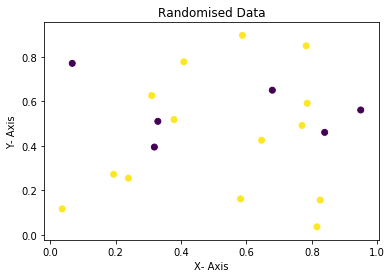

In [5]:
# Test Data
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

Data = np.random.rand(20,3)

Data[:,2] = np.round((Data[:,2]))
#Data = np.array([[0.0,0.0,1.0,0.0],[0.0,1.0,1.0,1.0],[1.0,0.0,1.0,1.0],[1.0,1.0,1.0,0.0]])
#Data[:,:3] = (Data[:,:3]-0.5)
print "Data:"
print Data[:,0:10]
print "Plot:"
plt.scatter(Data[:,0],Data[:,1],c=Data[:,-1] )
plt.xlabel('X- Axis')
plt.ylabel('Y- Axis')
plt.title('Randomised Data')
plt.show()
#plt.show(projection = '3d')

## Activation Functions
* __Sigmoid__ - $\sigma (z)$ :  \begin{eqnarray}
                  \sigma(z) &=&  \frac{1}{1+e^{-z}}\\
                  \frac{\delta \sigma(z)}{\delta z}  &=& \sigma(z)(1-\sigma(z))
                 \end{eqnarray}
* __RelU__ - $RelU (z)$ :  \begin{eqnarray}
                  RelU(z) &=& max(0,z)\\
                  \frac{\delta RelU(z)}{\delta z}  &=& (z>0)
                 \end{eqnarray}
* __Softmax__  - $sf(\hat{z})$ :  \begin{eqnarray}
                  sf(z)\vert _{i} &=&  \frac{e^{z_i}}{\sum_j e^{z_j}}\\
                  \frac{\delta (sf(z)\vert_i)}{\delta z_j}  &=& sf(z_{j})  - \delta_{ij} 
                 \end{eqnarray}
The __softmax function__ unlike the other functions takes a vector as an input, returns a vector as output. The $\delta_{ij}$ is the krnoecker delta function.

In [6]:
"""  Setting Activation function definition """

def activation(a,func='sigmoid',grad = False):
    if func == 'sigmoid':
        sigm = 1/(1.0 + np.exp(-a) )
        if grad == True:
            return np.multiply(sigm,1-sigm)
        else :
            return sigm
    if func == 'RelU':
        RelU = np.multiply(a>0,a)
        if grad == True:
            return np.double(a>0)
        else:
            return RelU 
    if func == 'Softmax':
        n,m = np.shape(a)
        f = np.exp(a)
        return np.divide(f,f.sum(axis=1).reshape(n,1))

In [7]:
""" Testing the activation function """

print 'Testing Sigmoid activation function'
print activation(Data[0,0],'sigmoid') # Answer should be 0.705
print 'Testing RelU activation function - Gradient'
print activation(Data[0,0],'RelU',grad = True)

Testing Sigmoid activation function
0.642936149829
Testing RelU activation function - Gradient
1.0


## Weight Initialization
The weight initilization is an important aspect when it comes to training neural nets. For example if all the weights are initilized to 0, then all the neurons in a particular layer will learn the same feature, which essentially means bad performance for the network. Before we jump into the the details let me introduce the conventions hat has been used.

The input layer is decribed by subscript 0. The indices of the hidden layer are in the range *1* to *L*, where *L* is the number of hidden layers. The output layer is represented by the subscript *L+1*. The notation $W_{i}$ represents the weights from hidden layer **i** to **i+1**. The notation $n_i$ is the number of neurons in hidden layer $i$.

The dimensions of weight matrix $W_{i}$ is ($n_{i},n_{i+1}$), the dimensions of the data matrix $X$ is ($m,n$) where $m$ is the number of training samples, $n$ is the number of features.



From **Andrew NG's deeplearning AI** lectures it is mentioned that the below following initilaizations work good. The intuition for the below is to scale the unit variance matrices such that the get the variance $\frac{\beta}{n} $ , where $\beta$ is a hyper parameter.
* Sigmoid/Tanh  : $ W_{i} = rand() \sqrt\frac{1}{ n_i} $
* RelU : $ W_{i} = rand() \sqrt\frac{ 2}{ n_i} $
* Xavier Initilization : $rand() \sqrt\frac{ 2}{ n_i * n_{i+1}} $

In [36]:
""" Generating Weight matrix """
# Restructuring Data
m,n = np.shape(Data)
x = Data[:,:n-1] # Seperating Data 
y = Data[:,n-1]
k = np.unique(y).size # No of labels

# Hidden Layer Structure

L = np.array([20]) 
# Contructing Weight Matrices
W = {'W0' : np.random.rand(n-1,L[0])-0.5, 'W'+str(len(L)) : np.random.rand(L[-1],k)-0.5  } # Weight dictionary initialization
for i in range(1,len(L)):
    name = 'W' + str(i)
    W_temp = {name : 2*np.random.rand(L[i-1],L[i])-1}
    W.update(W_temp)

print 'Weight Matrix Dict: W0'
print W['W0']

Weight Matrix Dict: W0
[[ 0.43324028  0.10048757  0.118079    0.32907201 -0.12082834  0.27037083
  -0.02565425  0.28550667 -0.27609378  0.39261954  0.2419108   0.10734765
   0.2228141  -0.19552302  0.31467672 -0.35607648 -0.10909109  0.02697427
   0.22318884 -0.1652774 ]
 [-0.19599848  0.19053972 -0.22236456 -0.00814252  0.01717311 -0.17383164
   0.47587107  0.18628519 -0.17664467 -0.32296685 -0.30187821 -0.22299745
  -0.40983875  0.13046714  0.46177153  0.18418796  0.16354989  0.28004492
  -0.23385548 -0.17886984]]


## Forward Propagation

The notaions $a_i$, $z_i$ represent the preactivation and the post activation at the hidden layer $i$. The notation $g$, $f$ is the activation function, softmax function respectively. The below are the follwing set of equations are the forward propagation equations.
 \begin{eqnarray}
a_0 &=& X\\
z_1 &=& a_0 W_{0}\\
a_1 &=& g(z_1)\\ 
\vdots  \\
z_{L+1} &=& a_{L}W_{L}\\
a_{L+1} &=& f(z_{L+1})\\ 
\end{eqnarray}

In [18]:
def forwardprop(x,W,activation_Func='sigmoid'):
    H = {} #Pre Activation
    a = {'a0' : x } # Post Activation
    for i in range(0,len(W)):
        H.update({'H' + str(i+1) : np.dot(a['a'+str(i)],W['W'+str(i)])})
        if (i==(len(W)-1)):
            a.update({'a' +str(i+1) : activation(H['H'+str(i+1) ],'Softmax')})
        else:
            a.update({'a' +str(i+1) : activation(H['H'+str(i+1) ],activation_Func)})
    return a,H

In [10]:
# Testing Forwardprop function
a,H = forwardprop(x,W)
# Checking equality by asserting all activation, preactivation values at the hidden layer, output layer.
assert(activation(np.dot(activation(np.dot(x,W['W0'])),W['W1']),func='Softmax') == a['a2']).all
assert(activation(np.dot(x,W['W0'])) == a['a1']).all
assert( H['H1'] == np.dot(x,W['W0'])).all
assert(H['H2'] ==  np.dot(activation(np.dot(x,W['W0'])),W['W1'])).all

## Back propagation
The below set of equations calculate the values $\delta_{i}$,$\delta_{a_i}$ represent the derivative of the **cost function** _wrt_ to the preactivation input, activation at hidden layer $i$ respectively which are very important in computing the gradients of the weight matrices. The symbol $\odot$ represents elementwise multiplication. 
\begin{eqnarray}
\delta_{L+1} &=& a_{L+1} - y\\
\delta_{a_{L}} &=& a_{L+1}W_{L}^{t} \\
\delta_{L} &=& \delta_{a_{L}}\odot\sigma (z_{L})\odot(1-\sigma(z_{L}) )\\
\vdots\\
\delta_{a_{1}} &=& a_{2}W_{1}^{t} \\
\delta_{1} &=& \delta_{a_{1}}\odot\sigma (z_{1})\odot(1-\sigma(z_{1}) )\\
\end{eqnarray}

Finally computing the gradients of the weights $W_{i}$
\begin{eqnarray}
W_{L} &=& a_{L}^{t} \delta_{a_{L+1}} \\
W_{L-1} &=& a_{L-1}^{t} \delta_{a_{L}} \\
\vdots\\
W_{1} &=& a_{1}^{t} \delta_{a_{2}}\\
W_{0} &=& a_{0}^{t} \delta_{a_{1}}\\
\end{eqnarray}



In [11]:
def backprop(x,y,W,Activation='sigmoid',iterations = 500):
    n,m  = np.shape(x)
    #for j in range(n):
    alpha = 1
    len_w = len(W)

    for i in range(iterations):
        a,H = forwardprop(x,W,Activation)
        len_a = len(a)
        
        pred = a['a' + str(len_a-1)]
        delta = {"delta"+str(len_a-1) : (-y+pred)}
        gradW = {}#'gradW' + str(len_w-1) : np.dot(a['a'+str(len_a-2)].T,(-y+pred))/n}
        #W.update({'W' + str(len_w-1) : W['W' + str(len_w-1)] - alpha*gradW['gradW' + str(len_w-1)] })
        
        for i in range(len(a)-2,0,-1):
            delta.update({'delta'+str(i) : np.multiply(np.dot(delta['delta'+str(i+1)],W['W'+str(i)].T),activation(H['H'+str(i)],grad=True)) })
            gradW.update({'gradW' + str(i) : np.dot(a['a'+str(i)].T,delta['delta' + str(i+1)])/n})             
            W.update({'W' + str(i) : W['W' + str(i)] - alpha*gradW['gradW' + str(i)] })
        
        gradW.update({'gradW0' : np.dot(x.T,delta['delta1'])/n})
        W.update({'W0' : W['W0'] - alpha*gradW['gradW0'] })
    return W

In [38]:
""" Checking Backprop"""

Y = np.zeros(shape = (m,k))

for i in range(m):
    
    Y[i,int(y[i])] = 1

W1 = backprop(x,Y,W.copy(),iterations=8000,Activation = 'sigmoid')

""" Asserting equality of the above backprop function"""
for i in range(1000):
    H1 = np.dot(x,W['W0'])
    a1 = activation(H1)
    H2 = np.dot(a1,W['W1'])
    
    a2 = activation(H2,func='Softmax')
    
    delta2 = a2-Y
    delta1 = np.multiply(np.dot(delta2,W['W1'].T),activation(H1,grad=True))
    
    gradw1 = np.dot(a1.T,delta2)/m
    gradw0 = np.dot(x.T,delta1)/m
    W['W1'] -= gradw1
    W['W0'] -= gradw0
    

""" Checking Equality of Weights"""
assert(W1['W1'] == W['W1']).all
assert(W1['W0'] == W['W0']).all
print 100 - np.sum(np.abs(np.round(a2) -Y))/x.shape[0]*100

60.0


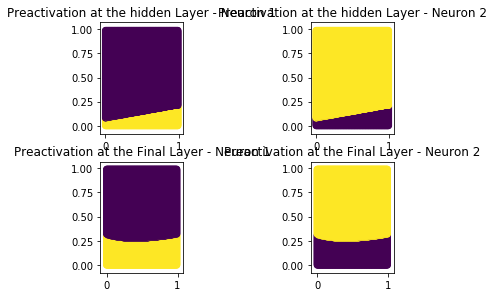

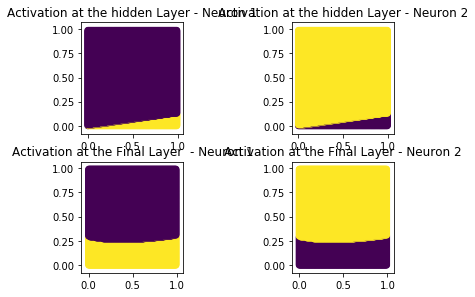

{'W1': array([[ 29.83715124, -29.57865753],
       [ -7.56398726,   7.26660894]]), 'W0': array([[ 0.84068604,  3.64905763],
       [-6.47530616,  0.3331538 ]])}


In [44]:
# Plotting Neural Net results
x_pl = np.array(range(0,100))/100.0
y_pl = np.array(range(0,100))/100.0
xv, yv = np.meshgrid(x_pl, y_pl, sparse=False, indexing='xy')
xv = xv.reshape(xv.size,1)
yv = yv.reshape(xv.size,1)

Data1 = np.concatenate((xv,yv),axis=1)
a,H = forwardprop(Data1,W1)

## Plotting various results
res = np.round(H['H'+str(len(H)-1)])
R = np.zeros(shape = (xv.size,2))
for i in range(xv.size):
    if res[i,0]>=0:
        R[i,0] = 1
    elif res[i,1]>=0:
        R[i,1] = 1
        
plt.subplot(2, 2, 1)
plt.scatter(xv,yv,c=R[:,0].reshape(xv.size,1))
plt.title('Preactivation at the hidden Layer - Neuron 1')
plt.subplot(2, 2, 2)
plt.scatter(xv,yv,c=R[:,1].reshape(xv.size,1))
plt.title('Preactivation at the hidden Layer - Neuron 2')
plt.tight_layout() 


res = np.round(H['H'+str(len(H))])
R1 = np.zeros(shape = (xv.size,2))
for i in range(xv.size):
    if res[i,0]>=0:
        R1[i,0] = 1
    elif res[i,1]>=0:
        R1[i,1] = 1

plt.subplot(2, 2, 3)
plt.scatter(xv,yv,c=R1[:,0].reshape(xv.size,1))
plt.title('Preactivation at the Final Layer - Neuron 1')
plt.subplot(2, 2, 4)
plt.scatter(xv,yv,c=R1[:,1].reshape(xv.size,1))
plt.title('Preactivation at the Final Layer - Neuron 2')
plt.show()



res = np.round(a['a'+str(len(a)-2)])
R = np.zeros(shape = (xv.size,2))
for i in range(xv.size):
    if res[i,0]==1:
        R[i,0] = 1
    elif res[i,1]==1:
        R[i,1] = 1
        
plt.subplot(2, 2, 1)
plt.scatter(xv,yv,c=R[:,0].reshape(xv.size,1))
plt.title('Activation at the hidden Layer - Neuron 1')
plt.subplot(2, 2, 2)
plt.scatter(xv,yv,c=R[:,1].reshape(xv.size,1))
plt.title('Activation at the hidden Layer - Neuron 2')
plt.tight_layout() 


res = np.round(a['a'+str(len(a)-1)])
R1 = np.zeros(shape = (xv.size,2))
for i in range(xv.size):
    if res[i,0]==1:
        R1[i,0] = 1
    else:
        R1[i,1] = 1

plt.subplot(2, 2, 3)
plt.scatter(xv,yv,c=R1[:,0].reshape(xv.size,1))
plt.title('Activation at the Final Layer  - Neuron 1')
plt.subplot(2, 2, 4)
plt.scatter(xv,yv,c=R1[:,1].reshape(xv.size,1))
plt.title('Activation at the Final Layer - Neuron 2')
plt.show()

print W
